<a href="https://colab.research.google.com/github/Aki-Kivivirta/Keyword-recognition-NN/blob/main/Keyword_recognition_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is a Colab notebook where a keyword classifier is built using PyTorch and the SPEECHCOMMANDS dataset. Audio can be classified to words by transforming the time domain waveform to frequency domain, and more over a spectrogram. After the transformation, image classification techniques, such as convoltional neural networks (CNN) can be used to label the spectrograms. In the end a CNN trained for 50 epochs could label the 35 different words with 80% accuracy.

### Notebook overview
First the dataset is split in to training, validation and test datasets, second the audio clips are transformed to Mel frequency spectrograms. Then the neural networks are trained and tested with the spectrograms. Finally the results are evaluated with the training and validation loss graph and test data classification confusion matrix.

### Preface
The main goal of this notebook was to learn how to build a keyword recognition neural network and to compile all I had learned in to a single neat notebook requiring as few imports as possible. I struggled with most steps on the way, but managed to get 50% accuracy on a CNN by myself. Then I found 
[Speech Command Classification using PyTorch and torchaudio](https://medium.com/@aminul.huq11/speech-command-classification-using-pytorch-and-torchaudio-c844153fce3b)
by Aminul Huq ([Git repo](https://github.com/aminul-huq/Speech-Classification)), where the exact same dataset is classified using PyTorch. Before this, I had mostly studied the [Colab keyword classification example](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb) and [Valerio Velardo's YouTube channel](https://www.youtube.com/c/ValerioVelardoTheSoundofAI). Prior to all of this I had a minor in machine learning and data science during my master in Aalto University and took one course on speech recognition.

### Install and import modules


In [1]:
!pip install torchaudio==0.9.0

                                   # Versions used:
import torch                       # torch==1.9.0+cu102
import torch.nn as nn              # torch==1.9.0+cu102
import torch.nn.functional as F    # torch==1.9.0+cu102
import torchaudio                  # torchaudio==0.9.0
import matplotlib.pyplot as plt    # matplotlib==3.2.2
import numpy as np                 # numpy==1.19.5
from IPython.display import Audio  # IPython==5.5.0

     |████████████████████████████████| 1.9 MB 3.8 MB/s 


### Select device
Using a GPU can make training, validating and testing neural networks significantly faster. To access Google's GPUs you can go to the **Runtime** dropdown, select **Change runtime type** and select **GPU** as your device under the **Hardware accelerator** dropdown.

In [2]:
# Define device which net is trained on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# See if GPU ('cuda') is available
print(device)

# Ref: https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device

cuda:0


### Process the dataset
Colab run out of storage while trying to download the train, validation and test datasets in the same session, which is why only the largest, i.e. the training dataset is used. 

Since some of the recordings are of different length and training in batches requires the files to be the same length, all files have to be made equal length. All samples have a sampling frequency of 16,000 and most samples are one second long, meaning they have 16,000 samples. An easy way to ensure equal length throughout the datasets is to zero pad or cut all samples to equal length.

Once all of the samples are equal length, the dataset can be split to training, validation and test datasets. It is important to split the samples randomly, like with *random_split*, so words are distributed equally to all datasets.

In [3]:
# Load the training dataset.
# Validation and test datasets can be accessed with subset='validation'/'test'.
# documentation: https://pytorch.org/audio/stable/datasets.html#speechcommands
speechcommands_dataset = torchaudio.datasets.SPEECHCOMMANDS("./", download=True, subset='training')

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [4]:
def extract_audio_and_labels(dataset_var, word_label_list=[]):

  # 'extract_audio_and_labels' takes in a dataset, makes sure all audio clips of
  # people saying words are one second long, (16,000 since sampling rate is
  # 16,000) and produces labels for each word. Since the training, validation 
  # and test dataset words should have the same labels, 'word_label_list' can
  # be given to the function as a variable if word label correlation has already
  # been defined. Unfortunately the free version of Colab could not handle
  # loading all the datasets. 'word_label_list' is a list containing all words
  # appearing in the dataset once. 'word_label_list.index(word)' returns the
  # index of a given word, which can be used as a label for that specific 'word'.

  # List for all the audio clips
  audio_list = []

  # List for number labels of words
  labels = []

  # Get the sampling rate of audio
  sampling_rate = next(iter(dataset_var))[1]

  # Loop through all samples in dataset
  for sample in dataset_var:
    # Extract the audio vector, make sure it is float accuracy, remove one dimension (squeeze) to match zeropad
    audio = torch.squeeze(sample[0].float())

    # Make sure all audio clips are one second long
    zero_pad = torch.zeros((sampling_rate-audio.shape[0]), dtype=torch.float)
    audio = torch.cat((zero_pad, audio), dim=0)

    # If the audio clip is longer than sampling rate (16,000 samples), use the last 16,000 samples
    if len(audio) > sampling_rate:
      audio = audio[-sampling_rate:]

    # Add the 16,000 sample long audio clip to a list
    audio_list.append(audio)

    # Extract the word
    word = sample[2]

    # Check if the word is in the label list, i.e. has a label
    if word not in word_label_list:
      word_label_list.append(word)

    # Add word's labels to list of labels
    labels.append(word_label_list.index(word))

  return audio_list, labels, word_label_list

In [5]:
# Unify the length of all data and label the data
audio_list, audio_labels, word_label_list = extract_audio_and_labels(speechcommands_dataset)

In [6]:
# Dataset documentation https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# says '__len__' and '__getitem__' methods have to be overriden. Luckily 
# https://github.com/aminul-huq/Speech-Classification/blob/master/dataloader.py
# can be used as a guide for the implementation.

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, data, labels, word_list):
    self.data = data
    self.labels = labels
    self.word_list = word_list

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index], self.labels[index]

In [7]:
# Reset the dataset variables now when all audio samples are 16,000 samples long
full_dataset = MyDataset(audio_list, audio_labels, word_label_list)

# Divide the full dataset with a 80%, 10%, 10% datasplit for training,
# validation and test datasets respectively. 'random_split' requires exact 
# integer lengths of each dataset.
training_set_length = int(np.floor(len(full_dataset)*0.8))
validation_set_length = int(np.floor(len(full_dataset)*0.1))
test_set_length = int(len(full_dataset)-training_set_length-validation_set_length)

# Divide the dataset
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, 
    [training_set_length, 
     validation_set_length, 
     test_set_length])

In [8]:
# Define batch size. The number of samples passed through a neural network in a
# single forward pass.
batch_size = 100

# In how many subthreads is the data loaded to the dataloader instance
number_of_sub_threads = 2

# Initialize data loaders
training_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=number_of_sub_threads)

validation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=number_of_sub_threads)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=number_of_sub_threads)


### Visualize data
Time domain signals represent the pressure fluctuations caused by sound. Using the Fourier transform, time domain signals can be transformed to their frequency components. By taking multiple Fourier transforms at some *hop_length* sample intervals, a spectrogram can be created. In a spectrogram, frequencies are on the vertical axis and time on the horizontal axis and the color represents the magnitude of that frequency at that specific time.

Since the human ear hears both frequency and magnitude logarithmically, the Mel scale and decibel (dB) transformation are used respectively. When ever a frequency doubles it is perceived one octave higher, meaning the interval relation between *200 Hz* and *400 Hz* is the same as *4000 Hz* and *8000 Hz* even though the latter has *20* fold amount of frequencies. To represent frequencies more like the human ear hears them, the Mel scale compresses high frequencies and expands low frequencies.

In listening tests *10 dB* difference between two levels has been identified as being twice as loud, which translates to approximately *3* fold increase in linear scale. To better represent the human ear perception and limit the overemphasis of high levels, the Mel spectrogram is transformed from linear to *dB* scale.

Most image recognition nets are implemented with rectagle images, which is why the spectrograms are resized using *F.interpolate* just before feeding them to the neural network.

Mel shape:  torch.Size([128, 41])


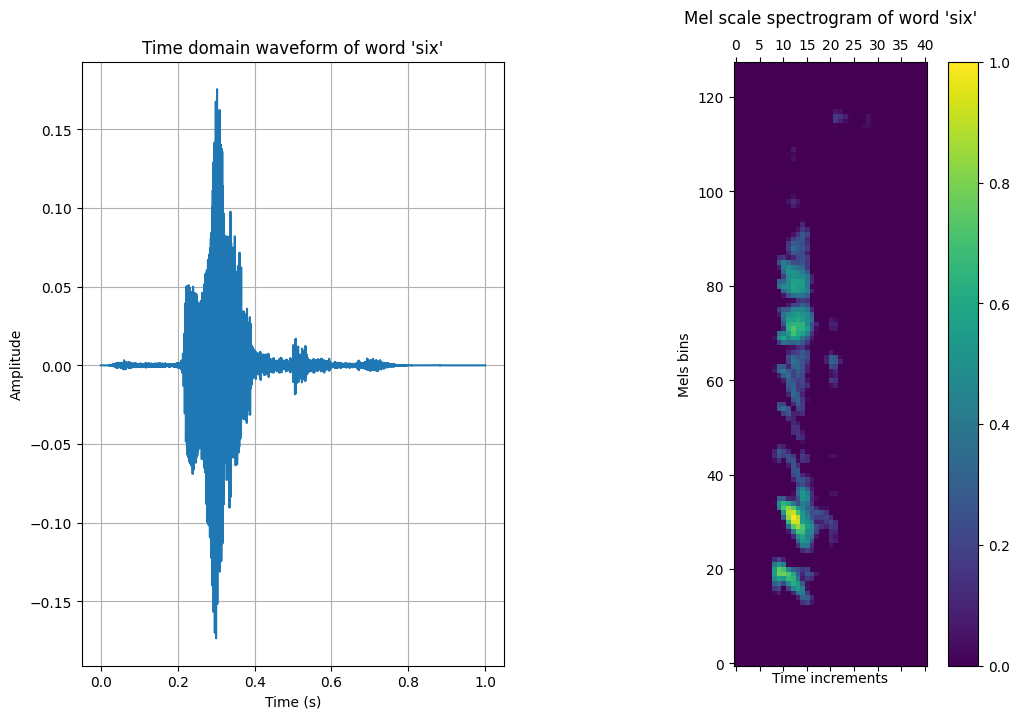

In [9]:
# An example of how the Mel spectrogram looks, feel free to comment the dB 
# conversion or the 0-1 scaling
random_sample_index = np.random.randint(low=0,high=training_set_length-1)
random_audio = train_dataset[random_sample_index][0].float()
word_label = train_dataset[random_sample_index][1]
word = word_label_list[word_label]

# Mel convertion hyperparameters
sampling_rate = speechcommands_dataset[0][1]
n_fft = int(np.floor(sampling_rate/10))
hop_length = int(np.floor(sampling_rate/40))
n_mels = 128

# Create Mel scale spectrogram
Mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate, 
                                                       n_fft=n_fft, 
                                                       hop_length=hop_length, 
                                                       n_mels=n_mels)(random_audio)

# Convert to dB scale, using default values from: https://curso-r.github.io/torchaudio/reference/functional_amplitude_to_db.html
# 'clamping' done with 'amin' did not quite behave how I expected and I do not
# understand the point in having 'db_multiplier'. However, the individual
# parameters were not se critical when experimenting, most likely because the
# values are scaled between 0 and 1. The most important thing is that dB
# conversion is done, so that linear scale high levels are not over emphasized
# and levels logarithmic like the human ear perceives them.
Mel_spectrogram = torchaudio.functional.amplitude_to_DB(Mel_spectrogram,
                                                        multiplier=20,
                                                        amin=1e-10,
                                                        db_multiplier=1,
                                                        top_db=80)

# Scale values between 0 and 1
Mel_spectrogram = (Mel_spectrogram-torch.min(Mel_spectrogram))
Mel_spectrogram = Mel_spectrogram/torch.max(np.abs(Mel_spectrogram)).item()

# Print spectrogram shape
print("Mel shape: ",Mel_spectrogram.shape)

# Change the displayed plot default size (more important for the confusion matrix in the end)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Plot waveform and spectrogram
fig, (ax1, ax2) = plt.subplots(1, 2)

# Waveform
ax1.plot(np.linspace(start=0, stop=1, num=sampling_rate), random_audio)
ax1.set_title("Time domain waveform of word '"+str(word)+"'")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

# Mel spectrogram
spec_im = ax2.matshow(Mel_spectrogram, origin='lower')
ax2.set_title("Mel scale spectrogram of word '"+str(word)+"'")
ax2.set_xlabel('Time increments')
ax2.set_ylabel('Mels bins')
fig.colorbar(spec_im);

Mel shape:  torch.Size([100, 100])


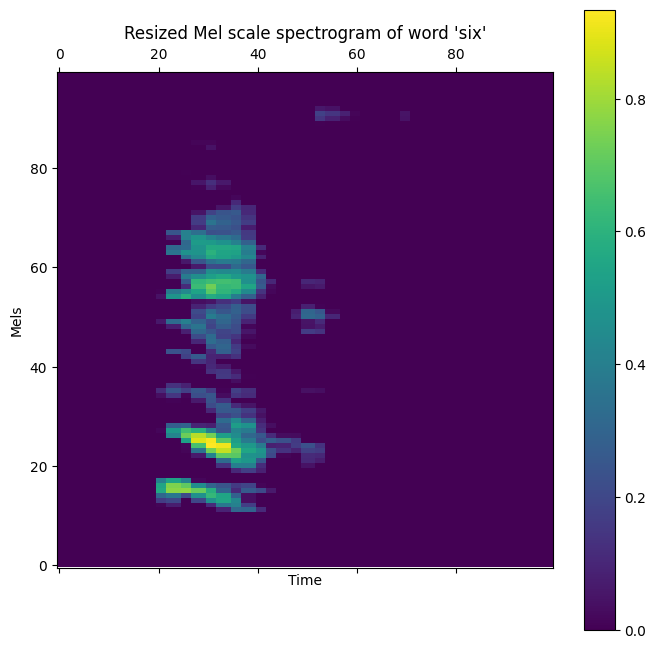

In [10]:
# Mel spectrograms are resized from rectangules to squares with F.interpolate.
# 'side' indicates the width and length of the final rectangle.
side = 100

# Add dimensions for the interpolation
Mel_spectrogram = torch.unsqueeze(torch.unsqueeze(Mel_spectrogram,dim=0) ,dim=0)

# Interpolate/resize
Mel_spectrogram = F.interpolate(Mel_spectrogram, size=side)

# Remove the added dimensions for plotting
Mel_spectrogram = torch.squeeze(torch.squeeze(Mel_spectrogram,dim=0) ,dim=0)

# Print spectrogram shape
print("Mel shape: ",Mel_spectrogram.shape)

# Plot spectrogram
plt.matshow(Mel_spectrogram, origin='lower')
plt.title("Resized Mel scale spectrogram of word '"+str(word)+"'")
plt.xlabel('Time')
plt.ylabel('Mels')
plt.colorbar(orientation="vertical")
plt.show()

In [11]:
# Create play bar for this audio sample. Some (windows) computer may need time
# for their audio outputs to activate, so if you don't hear anything try playing again.
Audio(data=random_audio, rate=sampling_rate)

###Neural network structures
As mentioned before, the word classification problem can be treated as an image classification problem, once the spectrogram has been produced. The simplest net will be to create all pixels to a single dense layer which has the same amount of output neurons as there are labels to be classified. However, more advanced image classifiers use 2-dimensional convolutions to get a better representation of how close by values are related.

In [12]:
class SimpleDenseNet(nn.Module):
  """
  The simplest net possible. This net simply maps all input pixels directly to
  all output neurons. Test accuracy was 24% after training for 50 epochs.
  """
  def __init__(self):
    super(SimpleDenseNet, self).__init__()

    self.audio_to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate, 
                                                       n_fft=n_fft, 
                                                       hop_length=hop_length, 
                                                       n_mels=n_mels)
    
    self.dense = nn.Linear(side*side,len(word_label_list))

  def forward(self, x):
    x = self.audio_to_mel_spectrogram(x)
    x = torch.squeeze(x, dim=1) # Remove one obsolete dimension
    x = F.interpolate(x, size=side)
    x = torch.flatten(x, start_dim=2, end_dim=3) # Flatten only the width and height, not the batch size (100) or the number of channels (1) [batch size, channels, width, height]
    x = self.dense(x)
    return x


class modified_NN2DMEL(nn.Module):
  """
  Net inspired by NN2DMEL in https://github.com/aminul-huq/Speech-Classification/blob/master/model.py
  which was the best performing net out of the three. Most notable changes were
  dB conversion, normalization and changing 'max_pool2d' 'stride' to be smaller
  than the default 'kernel_size'. In my mind, a smaller stride should translate 
  to more variation when overtones are active. In the end my net performs worst
  with 79% test accuracy compared to Huq's 84%, but that could also be due to
  different 'scheduler' type used.

  Please note that all internal structures have been made with 'side==100', and
  so any alterations to 'side' will most likely require also changes to the net.
  """
  def __init__(self):
    super(modified_NN2DMEL,self).__init__()

    self.audio_to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate, 
                                                       n_fft=n_fft, 
                                                       hop_length=hop_length, 
                                                       n_mels=n_mels)

    self.conv1 = nn.Conv2d(1,8,10)
    self.dropout_conv1 = nn.Dropout(0.3)

    self.conv2 = nn.Conv2d(8,16,5)
    self.dropout_conv2 = nn.Dropout(0.3)

    self.fc1 = nn.Linear(400,256)
    self.dropout1 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(256,128)
    self.dropout2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(128,len(word_label_list))

  def forward(self, x):
    # Transform to Mel scale spectrogram
    x = self.audio_to_mel_spectrogram(x)

    # Convert to dB scale
    x = torchaudio.functional.amplitude_to_DB(x, multiplier=20, amin=1e-10, db_multiplier=1, top_db=80)

    # Scale values between 0 and 1, since the maximum is taken from the entire
    # batch the entire batch is normalized with the largest value
    x = (x-torch.min(x))
    x = x/torch.max(torch.abs(x)).item()

    # Remove one obsolete dimension
    x = torch.squeeze(x, dim=1) 

    # Interpolate/resize
    x = F.interpolate(x, size=side)


    # Uncomment and add breaks to training and validation loop or the test loop 
    # to see what a spectrogram looks like going in to the neural network
    # plt.matshow(x[0][0], origin='lower')
    # plt.colorbar(orientation="horizontal")
    # plt.show()


    # 2D convolution layers with max pooling
    x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=10,stride=5)
    x = self.dropout_conv1(x)
    x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=5,stride=2)
    x = self.dropout_conv2(x)

    # Flatten and feed to dense layer with dropout
    x = torch.flatten(x, start_dim=1, end_dim=3)

    # Feed to first fully connected/dense layer with dropout
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    
    # Second dense layer with dropout
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)

    # Final dense layer to labels
    x = self.fc3(x)

    return x 


class CNN_3_conv2d(nn.Module):
  """
  A net inpired by 'modified_NN2DMEL', but with a third convolutional layer to 
  see if performance could be improved. The accuracy remained the same (80%) and 
  training 50 epochs took over an hour in Colab, which was significantly longer.
  """
  def __init__(self):
    super(CNN_3_conv2d,self).__init__()

    self.audio_to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate, 
                                                       n_fft=n_fft, 
                                                       hop_length=hop_length, 
                                                       n_mels=n_mels)

    self.conv1 = nn.Conv2d(1,8,12)
    self.dropout_conv1 = nn.Dropout(0.3)

    self.conv2 = nn.Conv2d(8,16,8)
    self.dropout_conv2 = nn.Dropout(0.3)

    self.conv3 = nn.Conv2d(16,32,4)
    self.dropout_conv3 = nn.Dropout(0.3)

    self.fc1 = nn.Linear(5408,1024)
    self.dropout1 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(1024,128)
    self.dropout2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(128,len(word_label_list))

  def forward(self, x):
    # Transform to Mel scale spectrogram
    x = self.audio_to_mel_spectrogram(x)

    # Convert to dB scale
    x = torchaudio.functional.amplitude_to_DB(x, multiplier=20, amin=1e-10, db_multiplier=1, top_db=80)

    # Scale values between 0 and 1, since the maximum is taken from the entire
    # batch the entire batch is normalized with the largest value
    x = (x-torch.min(x))
    x = x/torch.max(torch.abs(x)).item()

    # Remove one obsolete dimension
    x = torch.squeeze(x, dim=1) 

    # Interpolate/resize
    x = F.interpolate(x, size=side)


    # Uncomment and add breaks to training and validation loop or the test loop 
    # to see what a spectrogram looks like going in to the neural network
    # plt.matshow(x[0][0], origin='lower')
    # plt.colorbar(orientation="horizontal")
    # plt.show()


    # 2D convolution layers with max pooling
    x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=12,stride=1)
    x = self.dropout_conv1(x)
    x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=8,stride=2)
    x = self.dropout_conv2(x)
    x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=4,stride=2)
    x = self.dropout_conv3(x)

    # Flatten and feed to dense layer with dropout
    x = torch.flatten(x, start_dim=1, end_dim=3)

    # Feed to first fully connected/dense layer with dropout
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    
    # Second dense layer with dropout
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)

    # Final dense layer to labels
    x = self.fc3(x)

    return x 

### Training loop
The training loop consists of a training and a validation section. In the training section data is passed in the neural network and its parameters are adjusted with backpropagation. Validation dataset is like a mid training test dataset; it is separate from the training dataset and network parameters are not adjusted when using it. Validation data can be used to judge if the network has overfitted to its training data and the parameters with the lowest validation error can be stored as the best performing parameters for general data. [This GeeksForGeeks article](https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/) was helpful when implementing the validation loop structure. **Training SimpleDenseNet took over ten of minutes, modified_NN2DMEL closer to 20 minutes and CNN_3_conv2d well over an hour**, so please consider if you truly needed to run the training loop again.

In [13]:
# Initialize net
model = modified_NN2DMEL() # SimpleDenseNet() # CNN_3_conv2d() # 
model = model.float()
model = model.to(device)

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001 # Default lr, but it is nice to know where lr start since using a lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Reduce learning rate if validation error plateaus. This one and more advanced
# schedulers can be found in Ref: https://pytorch.org/docs/stable/optim.html
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       threshold=0.0001, 
                                                       threshold_mode='rel', 
                                                       cooldown=0, min_lr=0, 
                                                       eps=1e-08, 
                                                       verbose=True)

# Define the number of epochs
NUMBER_OF_EPOCHS = 50

# Store training and validation losses in their respective lists for plotting
training_losses = []
validation_losses = []

# Variable for keeping track of smallest validation loss
smallest_validation_loss = np.inf

#### Start training ####
for epoch in range(NUMBER_OF_EPOCHS):

  ### Training dataset loop ###
  training_loss = 0.0
  model.train() # Set neural network to training mode 
  for audio_batch, correct_labels in training_data_loader:

    # Set data and labels to be processed by the GPU. REMEMBER to set GPU
    # available in Colab from the 'Runtime' dropdown: 'Change runtime type ->
    # Hardware accellerator -> GPU'. You can always print 'device' to see if 
    # the GPU has been set up correctly.
    audio_batch, correct_labels = audio_batch.to(device), correct_labels.to(device)

    # Correct forward pass dimensions to [batch_size, channel, width, height]
    # batch size is 100, channel is 1 (in a rgb image there would be 3 channels),
    # and either of width or height is 16,000 and the other 1 which does not 
    # matter since the audio is transformed to a spectrogram which has width
    # and height of 'side' and one dimension of 1 is omitted. Here the final
    # dimension is [100, 1, 1, 16000], and after spectrogram and interpolation
    # [100, 1, 1, 1, 'side', 'side'] after which one of the middle dimensions is
    # removed with 'squeeze'.
    audio_batch = torch.unsqueeze(audio_batch, dim=1)
    audio_batch = torch.unsqueeze(audio_batch, dim=1)

    # Feed the training data batch to the neural net
    prediction = model(audio_batch)
    prediction = torch.squeeze(prediction,dim=1)

    # Calculate loss
    loss = criterion(prediction,correct_labels)

    # Backward propagation and optimizer step 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Cumulate training loss
    training_loss += loss.item()

    # Add breaks if you want to run a single forward pass
    #break
  #break

  ### Validation dataset loop ###
  validation_loss = 0.0
  model.eval() # Omits for example dropout layers
  for audio_batch, correct_labels in validation_data_loader:

    # Set the data and labels to be processed by the available processor
    audio_batch, correct_labels = audio_batch.to(device), correct_labels.to(device)

    # Correct dimensions for the forward pass
    audio_batch = torch.unsqueeze(audio_batch, dim=1)
    audio_batch = torch.unsqueeze(audio_batch, dim=1)

    # Feed the training data batch to the neural net
    prediction = model(audio_batch)
    prediction = torch.squeeze(prediction,dim=1)

    # Calculate loss
    loss = criterion(prediction,correct_labels)

    # Cumulate validation loss
    validation_loss += loss.item()

  # Divide losses by their respective lengths 
  training_loss = training_loss/len(training_data_loader)
  validation_loss = validation_loss/len(validation_data_loader)

  # Store losses for plotting 
  training_losses.append(training_loss)
  validation_losses.append(validation_loss)

  # Print current epoch's training and validation losses
  print("\nEpoch: "+str(epoch+1)+
        ",\t Training loss: "+str(round(training_loss,2))+
        ",\t Validation loss: "+str(round(validation_loss,2)))

  # Feed validation loss to lr_scheduler. If validation loss has not decreased 
  # (mode='min') in 'patience' number of epochs, 'lr' of 'optimizer' is
  # decreased. If lr is decreased it should print a message since 'verbose=True'.
  scheduler.step(validation_loss)

  # Save current model if it's parameters produced smaller validation loss than
  # the previous lowest validation loss
  if smallest_validation_loss > validation_loss:
    print("\nSaving new model...\nCumulative validation loss decreased from: "+
          str(round(smallest_validation_loss,3))+" to: "+
          str(round(validation_loss,3)))
    smallest_validation_loss = validation_loss

    # Save state for best parameters, used with validation set to prevent overfitting
    torch.save(model.state_dict(), 'best_parameters.pt')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch: 1,	 Training loss: 2.89,	 Validation loss: 2.06

Saving new model...
Cumulative validation loss decreased from: inf to: 2.064

Epoch: 2,	 Training loss: 2.06,	 Validation loss: 1.57

Saving new model...
Cumulative validation loss decreased from: 2.064 to: 1.571

Epoch: 3,	 Training loss: 1.78,	 Validation loss: 1.31

Saving new model...
Cumulative validation loss decreased from: 1.571 to: 1.313

Epoch: 4,	 Training loss: 1.6,	 Validation loss: 1.18

Saving new model...
Cumulative validation loss decreased from: 1.313 to: 1.177

Epoch: 5,	 Training loss: 1.47,	 Validation loss: 1.05

Saving new model...
Cumulative validation loss decreased from: 1.177 to: 1.053

Epoch: 6,	 Training loss: 1.39,	 Validation loss: 0.98

Saving new model...
Cumulative validation loss decreased from: 1.053 to: 0.982

Epoch: 7,	 Training loss: 1.34,	 Validation loss: 0.94

Saving new model...
Cumulative validation loss decreased from: 0.982 to: 0.942

Epoch: 8,	 Training loss: 1.29,	 Validation loss: 

###Network performance
The training and validation error curves should look like some type of exponential decay curves. In some networks the validation error can be lower that the training error, which could be explained by dropout layers being active only in the training phase. It is also possible that these errors would converge closer to one another in future epochs. However, intuitively a neural net should perform best on the data it is trained on.

With *SimpleDenseNet* it can be seen that both errors decrease in steps, which correlate to the epochs were learning rate was decreased by the *scheduler*.

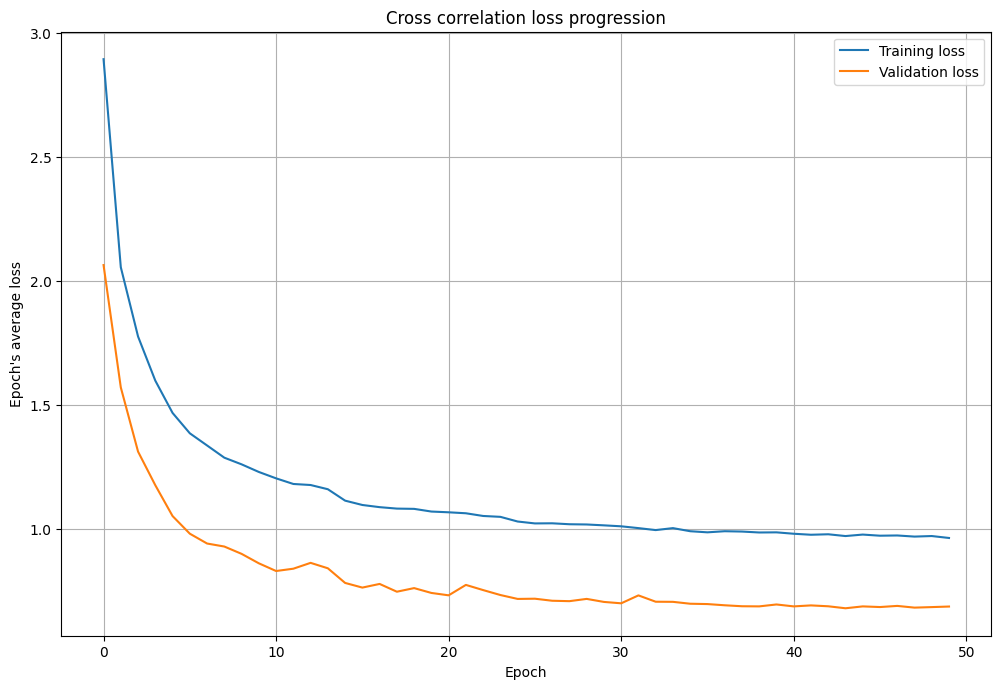

In [14]:
# Plot losses
train_plt, = plt.plot(training_losses, label='Training loss')
validation_plt, = plt.plot(validation_losses, label='Validation loss')
plt.legend(handles=[train_plt, validation_plt])

plt.title('Cross correlation loss progression')
plt.xlabel('Epoch')
plt.ylabel("Epoch's average loss")
plt.grid(True)
plt.show()

In [15]:
# Print the neural net architechture
print(model)

# How many trainable parameters are there in the net
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total amount of parameters:\t"+str(pytorch_total_params))
print("Trainable of parameters:\t"+str(pytorch_trainable_params))

modified_NN2DMEL(
  (audio_to_mel_spectrogram): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (conv1): Conv2d(1, 8, kernel_size=(10, 10), stride=(1, 1))
  (dropout_conv1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout_conv2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=35, bias=True)
)
Total amount of parameters:	144091
Trainable of parameters:	144091


###Test loop
The network performance can be judged the same way it is validated. The network outputs probabilities of the input waveform equaling to a specific label so the highest probability is simply chosen. A confusion matrix is calculated at the same time.

In [16]:
# Load the best performing model
model.load_state_dict(torch.load("best_parameters.pt"))

# Test the model with test dataset
test_loss = 0.0
model.eval()
correctly_labeled = 0

# Create empty confusion matrix
c_mat = np.zeros([len(word_label_list),len(word_label_list)])

### Loop the test dataset ###
for audio_batch, correct_labels in test_data_loader:
  
  # Set the data and labels to be processed by the available processor
  audio_batch, correct_labels = audio_batch.to(device), correct_labels.to(device)

  # Correct dimensions for the forward pass
  audio_batch = torch.unsqueeze(audio_batch, dim=1)
  audio_batch = torch.unsqueeze(audio_batch, dim=1)

  # Feed the training data batch to the neural net
  prediction = model(audio_batch)
  prediction = torch.squeeze(prediction,dim=1)

  # Calculate the amount of correctly labeled predictions
  correctly_labeled += sum(torch.argmax(prediction, dim=1)==correct_labels).item()

  # Add predictions and labels to lists, don't quite understand why len(correct_labels) != batch_size
  for ind in range(len(correct_labels)):
    c_mat[torch.argmax(prediction, dim=1)[ind].item(), correct_labels[ind].item()] += 1

# Print results
print("\nThe neural network predicted "+
      str(round(correctly_labeled/len(test_dataset)*100,2))+
      "% of the test dataset correctly.")

# Turn confusion matrix values to percentages. Since correct word labels are on
# the vertical axis and different words appear different amount of times in the
# dataset, each value is divided by the sum of its row which is the total amount
# of times a word appears in the test dataset.
for row in range(len(word_label_list)):
  c_mat[row,:] /= np.sum(c_mat[row,:])


The neural network predicted 78.86% of the test dataset correctly.


###Confusion matrix
A confusion matrix shows what are the true labels of predictions. Here, predictions are on the horizontal axis and true labels on the vertiacal axis. As an example, on one run with *modified_NN2DMEL*, the word *forward* was mislabeled as the word *four* *12%* of the time, but *four* was mislabeled as *fowrward* only *5%* of the time. One reason for this could be that there is simply more training data for the word *forward* than the word *four*.

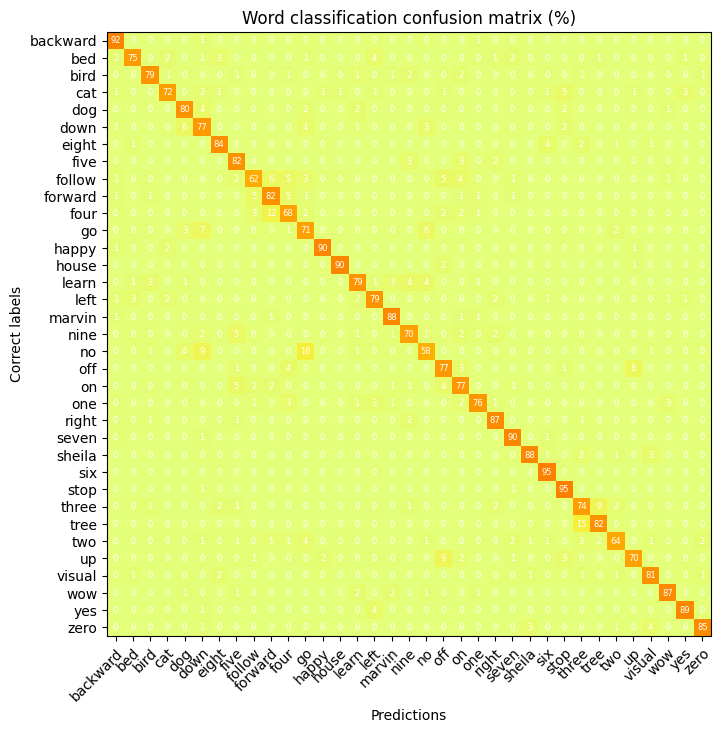

In [17]:
# Plot confusion matrix. Code mostly from example https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

_, ax = plt.subplots()
# Available colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Useful example: https://stackoverflow.com/questions/25625952/matplotlib-what-is-the-function-of-cmap-in-imshow
ax.imshow(c_mat, cmap='Wistia', interpolation='nearest') 

# We want to show all ticks...
ax.set_xticks(np.arange(len(word_label_list)))
ax.set_yticks(np.arange(len(word_label_list)))
# ... and label them with the respective list entries
ax.set_xticklabels(word_label_list)
ax.set_yticklabels(word_label_list)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(word_label_list)):
    for j in range(len(word_label_list)):
        text = ax.text(j, i, int(c_mat[i, j]*100),
                       ha="center", va="center", color="w", fontsize=6)

# Add title and master labels
plt.title("Word classification confusion matrix (%)")
plt.xlabel('Predictions')
plt.ylabel('Correct labels')
plt.show()

###Future development
In the future, test accuracy could be improved by looking in to more advanced image classifier techniques. The dataset could be augmented with noise and padding the recordings differently. Also, more complex learning rate schedulers have been shown to improve network performance.  

Continuous speech recognition is a more demanding task which uses some of the same techniques used in keyword recognition. [This article](https://towardsdatascience.com/customer-case-study-building-an-end-to-end-speech-recognition-model-in-pytorch-with-assemblyai-473030e47c7c) and its [Colab notebook](https://colab.research.google.com/drive/1IPpwx4rX32rqHKpLz7dc8sOKspUa-YKO#scrollTo=ydkqGeOwnPGY) seem like great sources to study in the future for continuous speech recognition.